In [0]:
!pip install git+https://github.com/keras-team/keras.git -U
!pip install seqeval
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install tensorflow-hub

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TimeDistributed, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, Lambda
from tensorflow.keras.layers import concatenate
# from sklearn.metrics import recall_score, precision_score
from seqeval.metrics import classification_report as classification_report_entity
from seqeval.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
print(tf.__version__)

2.0.0-alpha0


In [0]:
print(tf.keras.__version__)

2.2.4-tf


In [0]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


# Prepare data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
loc = '/content/gdrive/My Drive/tf2.0'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

plt.style.use("ggplot")

data = pd.read_csv(os.path.join(loc, "iob-labeled-sent-final-030519.csv"))
data = data.fillna(method="ffill")
data.head(15)

,para_index,sent,label,split_tag
0,0,By Jane Austen,O,train
1,1,Chapter 1,O,train
2,2,"It is a truth universally acknowledged, that a...",O,train
3,3,However little known the feelings or views of ...,O,train
4,4,"""My dear Mr Bennet,""",B-START,train
5,4,"""have you heard that Netherfield Park is...",I-START,train
6,5,Mr Bennet replied that he had not.,O,train
7,6,"""But it is,""",B-OTHER,train
8,6,"""for Mrs Long has just been here, and she told...",I-OTHER,train
9,7,Mr Bennet made no answer.,O,train


In [7]:
tags = list(set(data["label"].values))
n_tags = len(tags); tags

['I-START', 'I-OTHER', 'O', 'B-START', 'B-OTHER']

In [0]:
class paragraphGetter(object):
    
    def __init__(self, data):
        self.n_para = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["sent"].values.tolist(),
                                                           s["split_tag"].values.tolist(),
                                                           s["label"].values.tolist())]
        self.grouped = self.data.groupby("para_index").apply(agg_func)
        print(self.grouped)
        self.paragraphs = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["paragraph: {}".format(self.n_para)]
            print(s)
            self.n_para += 1
            return s
        except:
            return None

In [9]:
getter = paragraphGetter(data)

para_index
0                            [(By Jane Austen, train, O)]
1                                 [(Chapter 1, train, O)]
2       [(It is a truth universally acknowledged, that...
3       [(However little known the feelings or views o...
4       [("My dear Mr Bennet,", train, B-START), ("hav...
5        [(Mr Bennet replied that he had not., train, O)]
6       [("But it is,", train, B-OTHER), ("for Mrs Lon...
7                 [(Mr Bennet made no answer., train, O)]
8       [("Do you not want to know who has taken it?",...
9       [("You want to tell me, and I have no objectio...
10               [(This was invitation enough, train, O)]
11      [("Why, my dear, you must know, Mrs Long says ...
12                [("What is his name?", train, B-OTHER)]
13                         [("Bingley.", train, B-OTHER)]
14         [("Is he married or single?", train, B-OTHER)]
15      [("Oh! Single, my dear, to be sure! A single m...
16      [("How so? How can it affect them?", train, B-...
17 

In [0]:
paragraphs = getter.paragraphs

In [11]:
print(paragraphs[0])

[('By Jane Austen', 'train', 'O')]


In [0]:
max_len = 10
batch_size = 16
EPOCHS = 3
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
X_ori = [[w[0] for w in s] for s in paragraphs]

X = []
for seq in X_ori:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PAD")
    X.append(new_seq)
X[0]

['By Jane Austen',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [0]:
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()

In [22]:
def bertSentenceEmbedding(x):
  embeddings = []
  count = 0
  for para in x:
#     count = 0
#     print(para)
    para_all_embed = np.asarray(bert_embedding(para))[:,1]
  
    para_embed = []
    for embed in np.asarray(para_all_embed):
      count = 0
      all_embed = [0]*768
      for word_embed in embed:
        count += 1
        all_embed = all_embed + word_embed
#       print(count)
      sent_embed = all_embed/count
      para_embed.append(sent_embed)
      
    embeddings.append(para_embed)
#     print(np.asarray(bert_embedding(para)))
  return embeddings

xxx = [['hi hello world joyce','hi joyce'],['hi hello joyce','joyce'] ]

res = bertSentenceEmbedding(xxx)
print(np.asarray(res).shape)
# print(res[0])

(2, 2, 768)


In [0]:
X_embed = bertSentenceEmbedding(X)
np.save(os.path.join(loc, "X_embeeding.npy"), X_embed)

In [23]:
y = [[tag2idx[w[2]] for w in s] for s in paragraphs]

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y[0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [26]:
from sklearn.model_selection import train_test_split

batch = 1

X_tra, X_te, y_tra, y_te = train_test_split(X, y, test_size=0.2, random_state=2019)

X_tr, X_val, y_tr, y_val = train_test_split(X_tra, y_tra, test_size=0.1, random_state=2019)
X_tr = X_tr[0:int(np.floor(len(X_tr)/batch_size)*batch_size)]
X_val = X_val[0:int(np.floor(len(X_val)/batch_size)*batch_size)]
y_tr = y_tr[0:int(np.floor(len(y_tr)/batch_size)*batch_size)]
y_val = y_val[0:int(np.floor(len(y_val)/batch_size)*batch_size)]
print("training sentences: ", len(X_tr), "validation sentences: ", len(X_val))
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

training sentences:  1520 validation sentences:  160


In [0]:
X_test_embed = bertSentenceEmbedding(X_te)
np.save(os.path.join(loc, "X_test_embeeding.npy"), X_test_embed)

# Build model

In [0]:
# from tensorflow.keras.layers import concatenate
# # Function to build model
# def build_model():
#     input_text = Input(shape=(max_len,), dtype="string")
#     embedding = Lambda(bertSentenceEmbeddingLayer, output_shape=(None, 1024))(input_text)
# #     embedding = Embedding(2747, 500, input_length=max_len)(input_text)
#     x = Bidirectional(LSTM(units=512, return_sequences=True,
#                            recurrent_dropout=0.2, dropout=0.2))(input_text)
#     x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
#                                recurrent_dropout=0.2, dropout=0.2))(x)
#     x = concatenate([x, x_rnn])  # residual connection to the first biLSTMSS
#     out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

#     model = Model(input_text, out)
#     model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
#     model.summary()

#     return model

In [0]:
filepath = os.path.join(loc, "fiction-elmo-iob-epoch-{epoch:02d}.hdf5")
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False,
                             mode='auto', period=1)
callbacks_list = [checkpoint]

In [0]:
from tensorflow.keras.layers import concatenate
# Function to build model
def build_model():
    input_text = Input(shape=(None, max_len))
#     embedding = Lambda(bertSentencembedding, output_shape=(None, 1024))(input_text)
#     embedding = Embedding(2747, 500, input_length=max_len)(input_text)
    x = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(input_text)
    x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)
    x = concatenate([x, x_rnn])  # residual connection to the first biLSTMSS
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

    model = Model(input_text, out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
    model.summary()

    return model

In [0]:
model = build_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, 20)]   0                                            
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, None, 1024)   2183168     input_10[0][0]                   
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, None, 1024)   6295552     bidirectional_12[0][0]           
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, None, 2048)   0           bidirectional_12[0][0]           
                                                                 bidirectional_13[0][0]     

In [0]:
# from tensorflow.keras.models import Sequential
# model = Sequential()

# model.add(LSTM(512, input_shape=(None,20)))
# model.add(Dense(n_tags, activation='softmax'))
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_19 (UnifiedLSTM (None, 512)               1091584   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 1,094,149
Trainable params: 1,094,149
Non-trainable params: 0
_________________________________________________________________
None


# Fit model

In [0]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

In [0]:
from keras.utils import plot_model

# plot_model(model, to_file='model_lstm_elmo.png')
print("Model built. Saved model.png")

In [0]:
import time

timestr = time.strftime("%m%d_%H%M")

In [0]:
np.save(os.path.join(loc, "idx2label_" + timestr + "-" + str(EPOCHS) + ".npy"), idx2label)
np.save(os.path.join(loc, "word2idx_" + timestr + "_" + str(EPOCHS) + ".npy"), word2idx)

In [0]:
model_name = "lstm_elmo_v5_" + timestr + "_epoch" + str(EPOCHS)
model_name_path = os.path.join(loc, model_name + ".h5")
model.save(model_name_path)

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend()
plt.show()

# Model evaluation

In [123]:
from tensorflow.keras.models import load_model
import os

model_load = load_model(os.path.join(loc, "fiction_lstm_elmo_v1_0504_1631_epoch30.h5"))

W0504 16:45:02.116267 139845056681856 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f2ee9b1a978>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0504 16:45:02.121426 139845056681856 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f2ee92f7d68>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0504 16:45:02.128668 139845056681856 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f2efaae6198>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0504 16:45:02.131377 139845056681856 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f2efaaea668>: Note that this layer is not optimized for performance. Please use tf.keras.laye

In [34]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

category_count = {'B-START':0, 'I-START':0, 'B-OTHER':0, 'I-OTHER':0, 'O':0}
total_count = 0

for sentence in paragraphs:
    for word in sentence:
        if word[2] in category_count.keys():
            category_count[word[2]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count / total_count) * 100, 2)))


B-START: 6.81%
I-START: 5.9%
B-OTHER: 36.8%
I-OTHER: 13.83%
O: 36.66%


In [0]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            #             print(p)
            out_i.append(idx2tag[p].replace("PAD", "O"))
        #           print(out_i)
        out.append(out_i)
    return out


def y2label(y):
    out = []
    for y_i in y:
        out_i = []
        for p in y_i:
            for p_i in p:
                out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

In [0]:
def evaluate_performance(X, y):
    pred_num = model.predict(np.array(X))
    pred = np.argmax(pred_num, axis=-1)
    pred_labels = pred2label(pred)
    labels = y2label(y)
    print(classification_report(labels, pred_labels))
    return pred

In [0]:
def evaluate_performance_v2(X, y):
    pred_num = model_load.predict(np.array(X))
    pred = np.argmax(pred_num, axis=-1)
    pred_labels = pred2label(pred)
    y_num = y[0:int(np.floor(len(X)/batch_size)*batch_size)]
    y_labels = pred2label2(y_num)
    print(classification_report(y_labels, pred_labels))
    return pred

In [0]:
idx2tag = {0: 'B-START', 1: 'O', 2: 'B-OTHER', 3: 'I-OTHER', 4: 'I-START'}
tag2idx = {v: k for k, v in tag2idx2.items()}

In [139]:
pred_test = evaluate_performance_v2(X_test_embed, y_te)

           precision    recall  f1-score   support

    START       0.28      0.11      0.16        44
    OTHER       0.79      0.96      0.87       194

micro avg       0.75      0.81      0.78       238
macro avg       0.69      0.81      0.74       238



In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(os.path.join(loc, "fiction_bert_lstm_evaluation_model_v1_eva_test_conf.jpg"))
    plt.show()

In [0]:
# y_test = y_te[0:int(np.floor(len(X_te)/batch_size)*batch_size)]
# X_test = X_te[0:int(np.floor(len(X_te)/batch_size)*batch_size)]
# test_pred = evaluate_performance(X_test, y_test)
label_pred = []
idx_pred = []

for sentence in pred_test:
    for element in sentence:
        idx_pred.append(element)
        label_pred.append(idx2tag[element])

label_correct = []
idx_correct = []
for sentence in y_te:
    for element in sentence:
        idx_correct.append(element)
        label_correct.append(idx2tag[element])

In [0]:
from sklearn.metrics import confusion_matrix
cm_with_o = confusion_matrix(label_correct, label_pred)

In [144]:
import pandas as pd
df = pd.DataFrame(cm_with_o)
df_wo_o = df.iloc[:-1, :-1]
cm = df_wo_o.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [148]:
labels = list(idx2tag.values())
labels.remove('O')
labels

['B-START', 'B-OTHER', 'I-OTHER', 'I-START']

In [149]:
labels_sorted = sorted(labels)
labels_sorted

['B-OTHER', 'B-START', 'I-OTHER', 'I-START']

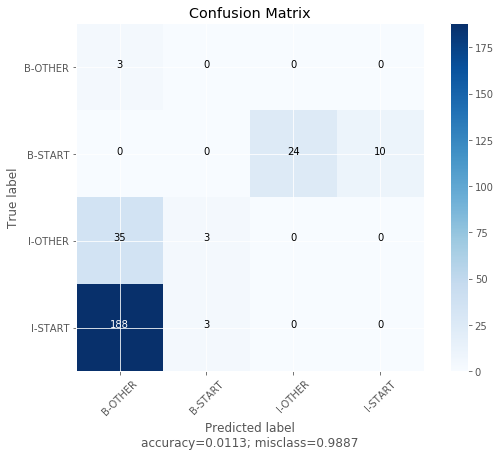

In [153]:
plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = labels_sorted,
                      title        = "Confusion Matrix")

In [151]:
from sklearn.metrics import classification_report as classification_report_all

print(classification_report_all(label_correct, label_pred,
                                labels=labels_sorted,
                                digits=3))

              precision    recall  f1-score   support

     B-OTHER      0.013     0.001     0.001      3900
     B-START      0.000     0.000     0.000        34
     I-OTHER      0.000     0.000     0.000        38
     I-START      0.000     0.000     0.000       191

   micro avg      0.009     0.001     0.001      4163
   macro avg      0.003     0.000     0.000      4163
weighted avg      0.012     0.001     0.001      4163

